In [1]:
from numpy.linalg import norm
import numpy as np
import pandas as pd
import random

from sklearn.linear_model import RANSACRegressor
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pptk

import pcl

from MinimumBoundingBox import MinimumBoundingBox
from scipy.stats import linregress
from scipy.spatial import ConvexHull
from matplotlib.path import Path

from scipy.spatial import distance
from scipy.optimize import linear_sum_assignment

from time import perf_counter
import glob
import sys
sys.path.remove(sys.path[2])
import cv2

In [2]:
def load_from_bin(bin_path):
    
    obj = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return obj[:,:3]

In [3]:
def link(p1,p2, link_intensity):
    
    return np.linspace(p1, p2, num=int(norm(p1-p2)*link_intensity))

In [4]:
def convex_hull(pcl, intensity=150):
    
    hull = ConvexHull(pcl[:,:2])
    hull_path = Path( pcl[:,:2][hull.vertices] )
    results = np.vstack(hull_path.to_polygons())[:-1]
    n = results.shape[0]
    
    z_min, z_max = pcl[:,2].min(), pcl[:,2].max()
    down_points = np.hstack((results, z_min*np.ones(shape=(n,1))))
    up_points = np.hstack((results, z_max*np.ones(shape=(n,1))))
    
    box = np.zeros((0,3))

    for k in range(n):
        box = np.vstack((box, link(down_points[k%n], down_points[(k+1)%n], link_intensity=intensity)))
    for k in range(n):
        box = np.vstack((box, link(up_points[k%n], up_points[(k+1)%n], link_intensity=intensity)))
    for k in range(n):
        box = np.vstack((box, link(down_points[k%n], up_points[k%n], link_intensity=intensity)))
    
    return box

In [5]:
def process(pcl, e=0.3, outer_radius=40, inner_radius=2.74, min_cluster_size=20):
    
    coords = pcl.to_array()
    coords = coords[(norm(coords[:,:2], axis=1)<=outer_radius)]
    coords = coords[(norm(coords, axis=1)>inner_radius)]
    coords = coords[coords[:,2]>-2.2]
    
    x, y, z = coords[:,0], coords[:,1], coords[:,2]
    
    ptf = coords[z<-1.3]
    reg = RANSACRegressor()
    reg.fit(ptf[:,:2],ptf[:,2])
    preds = (reg.predict(ptf[:,:2])-ptf[:,2])
    std_z = preds.std()
    mean_z = reg.predict(ptf[:,:2]).mean()
    
    to_cluster = coords[z>mean_z+1.9*std_z]
    
    clst = DBSCAN(eps=e)
    clst.fit(to_cluster)
    clst_labels = clst.labels_
    labels, counts = np.unique(clst_labels, return_counts=True)
    
    to_cluster = to_cluster[np.isin(clst_labels, labels[counts>min_cluster_size])]
    clst_labels = clst_labels[np.isin(clst_labels, labels[counts>min_cluster_size])]
    bhulls = np.vstack([convex_hull(to_cluster[clst_labels==k], intensity=50) for k in np.unique(clst_labels)[1:]])
    
    return to_cluster, clst_labels, bhulls

In [6]:
def visualize_detections(to_cluster, clst_labels, bhulls):
    
    viz_pcl = np.vstack((to_cluster, bhulls))
    bhull_color = int(np.quantile(np.unique(clst_labels)[1:], .70))
    clst_labels = np.hstack((clst_labels, bhull_color*np.ones(bhulls.shape[0])))
    
    return viz_pcl, clst_labels

In [7]:
i = 1
pcd1 = pcl.PointCloud(load_from_bin('data/'+'%010d.bin'%i))
pcd2 = pcl.PointCloud(load_from_bin('data/'+'%010d.bin'%(i+1)))

#i = 19
#pcd1 = pcl.load('data_1/%010d.pcd'%i)
#v1 = pptk.viewer(*visualize_detections(*process(pcd1, min_cluster_size=mcs)))
#v1.set(lookat=[0,0,0])
#v1.set(phi=np.pi, theta=np.pi/2, r=50)

#pcd2 = pcl.load('data_1/%010d.pcd'%(i+1))
#v2 = pptk.viewer(*visualize_detections(*process(pcd2, min_cluster_size=mcs)))
#v2.set(lookat=[0,0,0])
#v2.set(phi=np.pi, theta=np.pi/2, r=50)

In [8]:
mcs = 100
eps = 0.5
to_cluster1, clst_labels1, bhulls1 = process(pcd1, min_cluster_size=mcs, e=eps)
to_cluster2, clst_labels2, bhulls2 = process(pcd2, min_cluster_size=mcs, e=eps)
tracked_clst_labels2 = clst_labels2.copy()

In [9]:
df1 = pd.DataFrame(np.hstack((to_cluster1[:,:2], clst_labels1.reshape(-1,1))), columns=['x','y','cluster']).groupby('cluster')\
                    .apply(lambda x: np.array(MinimumBoundingBox(x.values[:,:-1]).rectangle_center))

In [10]:
df2 = pd.DataFrame(np.hstack((to_cluster2[:,:2], clst_labels2.reshape(-1,1))), columns=['x','y','cluster']).groupby('cluster')\
                    .apply(lambda x: np.array(MinimumBoundingBox(x.values[:,:-1]).rectangle_center))

In [11]:
df1_old = pd.DataFrame(np.hstack((to_cluster1[:,:2], clst_labels1.reshape(-1,1))), columns=['x','y','cluster']).groupby('cluster').mean()
df2_old = pd.DataFrame(np.hstack((to_cluster2[:,:2], clst_labels2.reshape(-1,1))), columns=['x','y','cluster']).groupby('cluster').mean()

In [12]:
cost = distance.cdist(np.vstack(df1), np.vstack(df2))
row_ind, col_ind = linear_sum_assignment(cost)

In [13]:
for i in range(col_ind.shape[0]):
    old_mask = clst_labels2==int(df1.index[row_ind][i])
    tracked_clst_labels2[clst_labels2==int(df2.index[col_ind][i])] = int(df1.index[row_ind][i])
    tracked_clst_labels2[old_mask] = int(df2.index[col_ind][i])

We neeed to visualize tracks using MatPlotLib or By improving the Visualizer function

In [14]:
props = dict(boxstyle='round', facecolor='wheat', alpha=1)

(-20, 20)

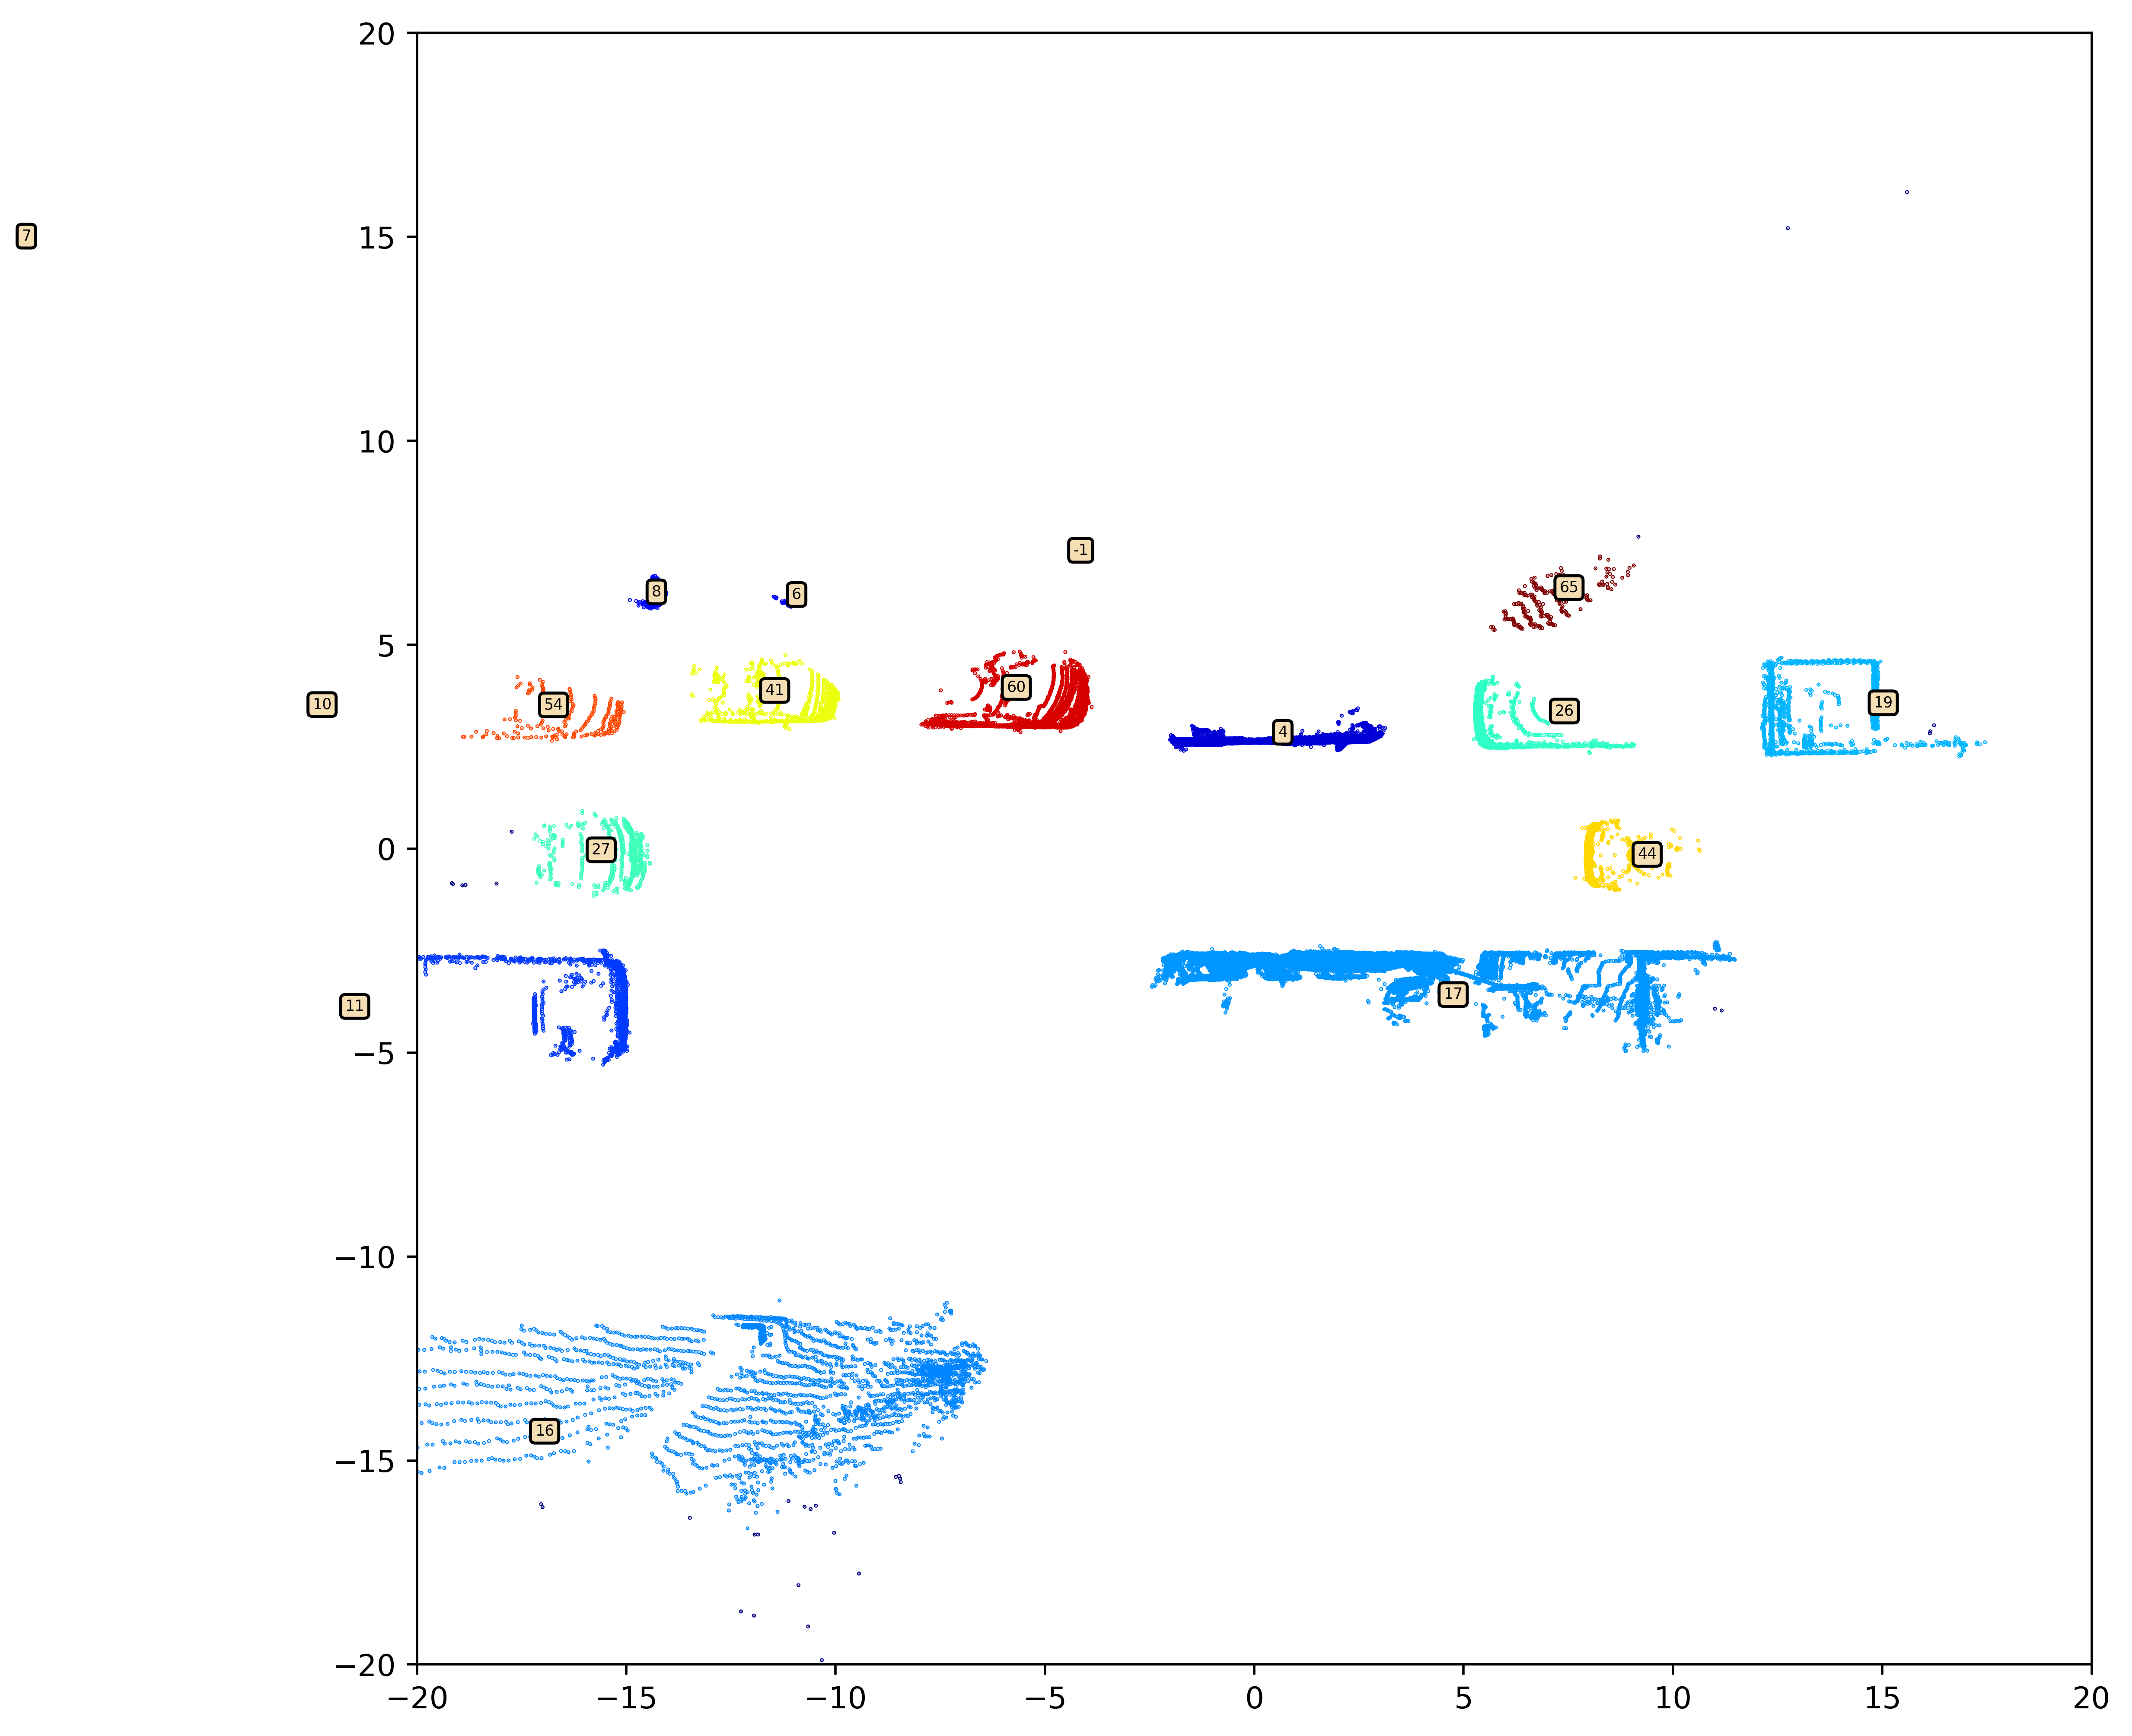

In [17]:
plt.figure(figsize=(10, 10), dpi=500)
plt.scatter(x=to_cluster1[:,0], y=to_cluster1[:,1], c=clst_labels1, s=0.1, cmap='jet')
for k in range(0,df1.shape[0]): 
    #plt.text(*df1.iloc[k,:2].values, str(int(df1.index.values[k])), fontsize=5, bbox=props)
    plt.text(*df1.iloc[k], str(int(df1.index.values[k])), fontsize=5, bbox=props)
plt.xlim(-20,20)
plt.ylim(-20,20)
#plt.savefig('df1.png')
#plt.show()

In [18]:
df2_t = pd.DataFrame(np.hstack((to_cluster2[:,:2], tracked_clst_labels2.reshape(-1,1))), columns=['x','y','cluster']).groupby('cluster')\
                    .apply(lambda x: np.array(MinimumBoundingBox(x.values[:,:-1]).rectangle_center))

(-20, 20)

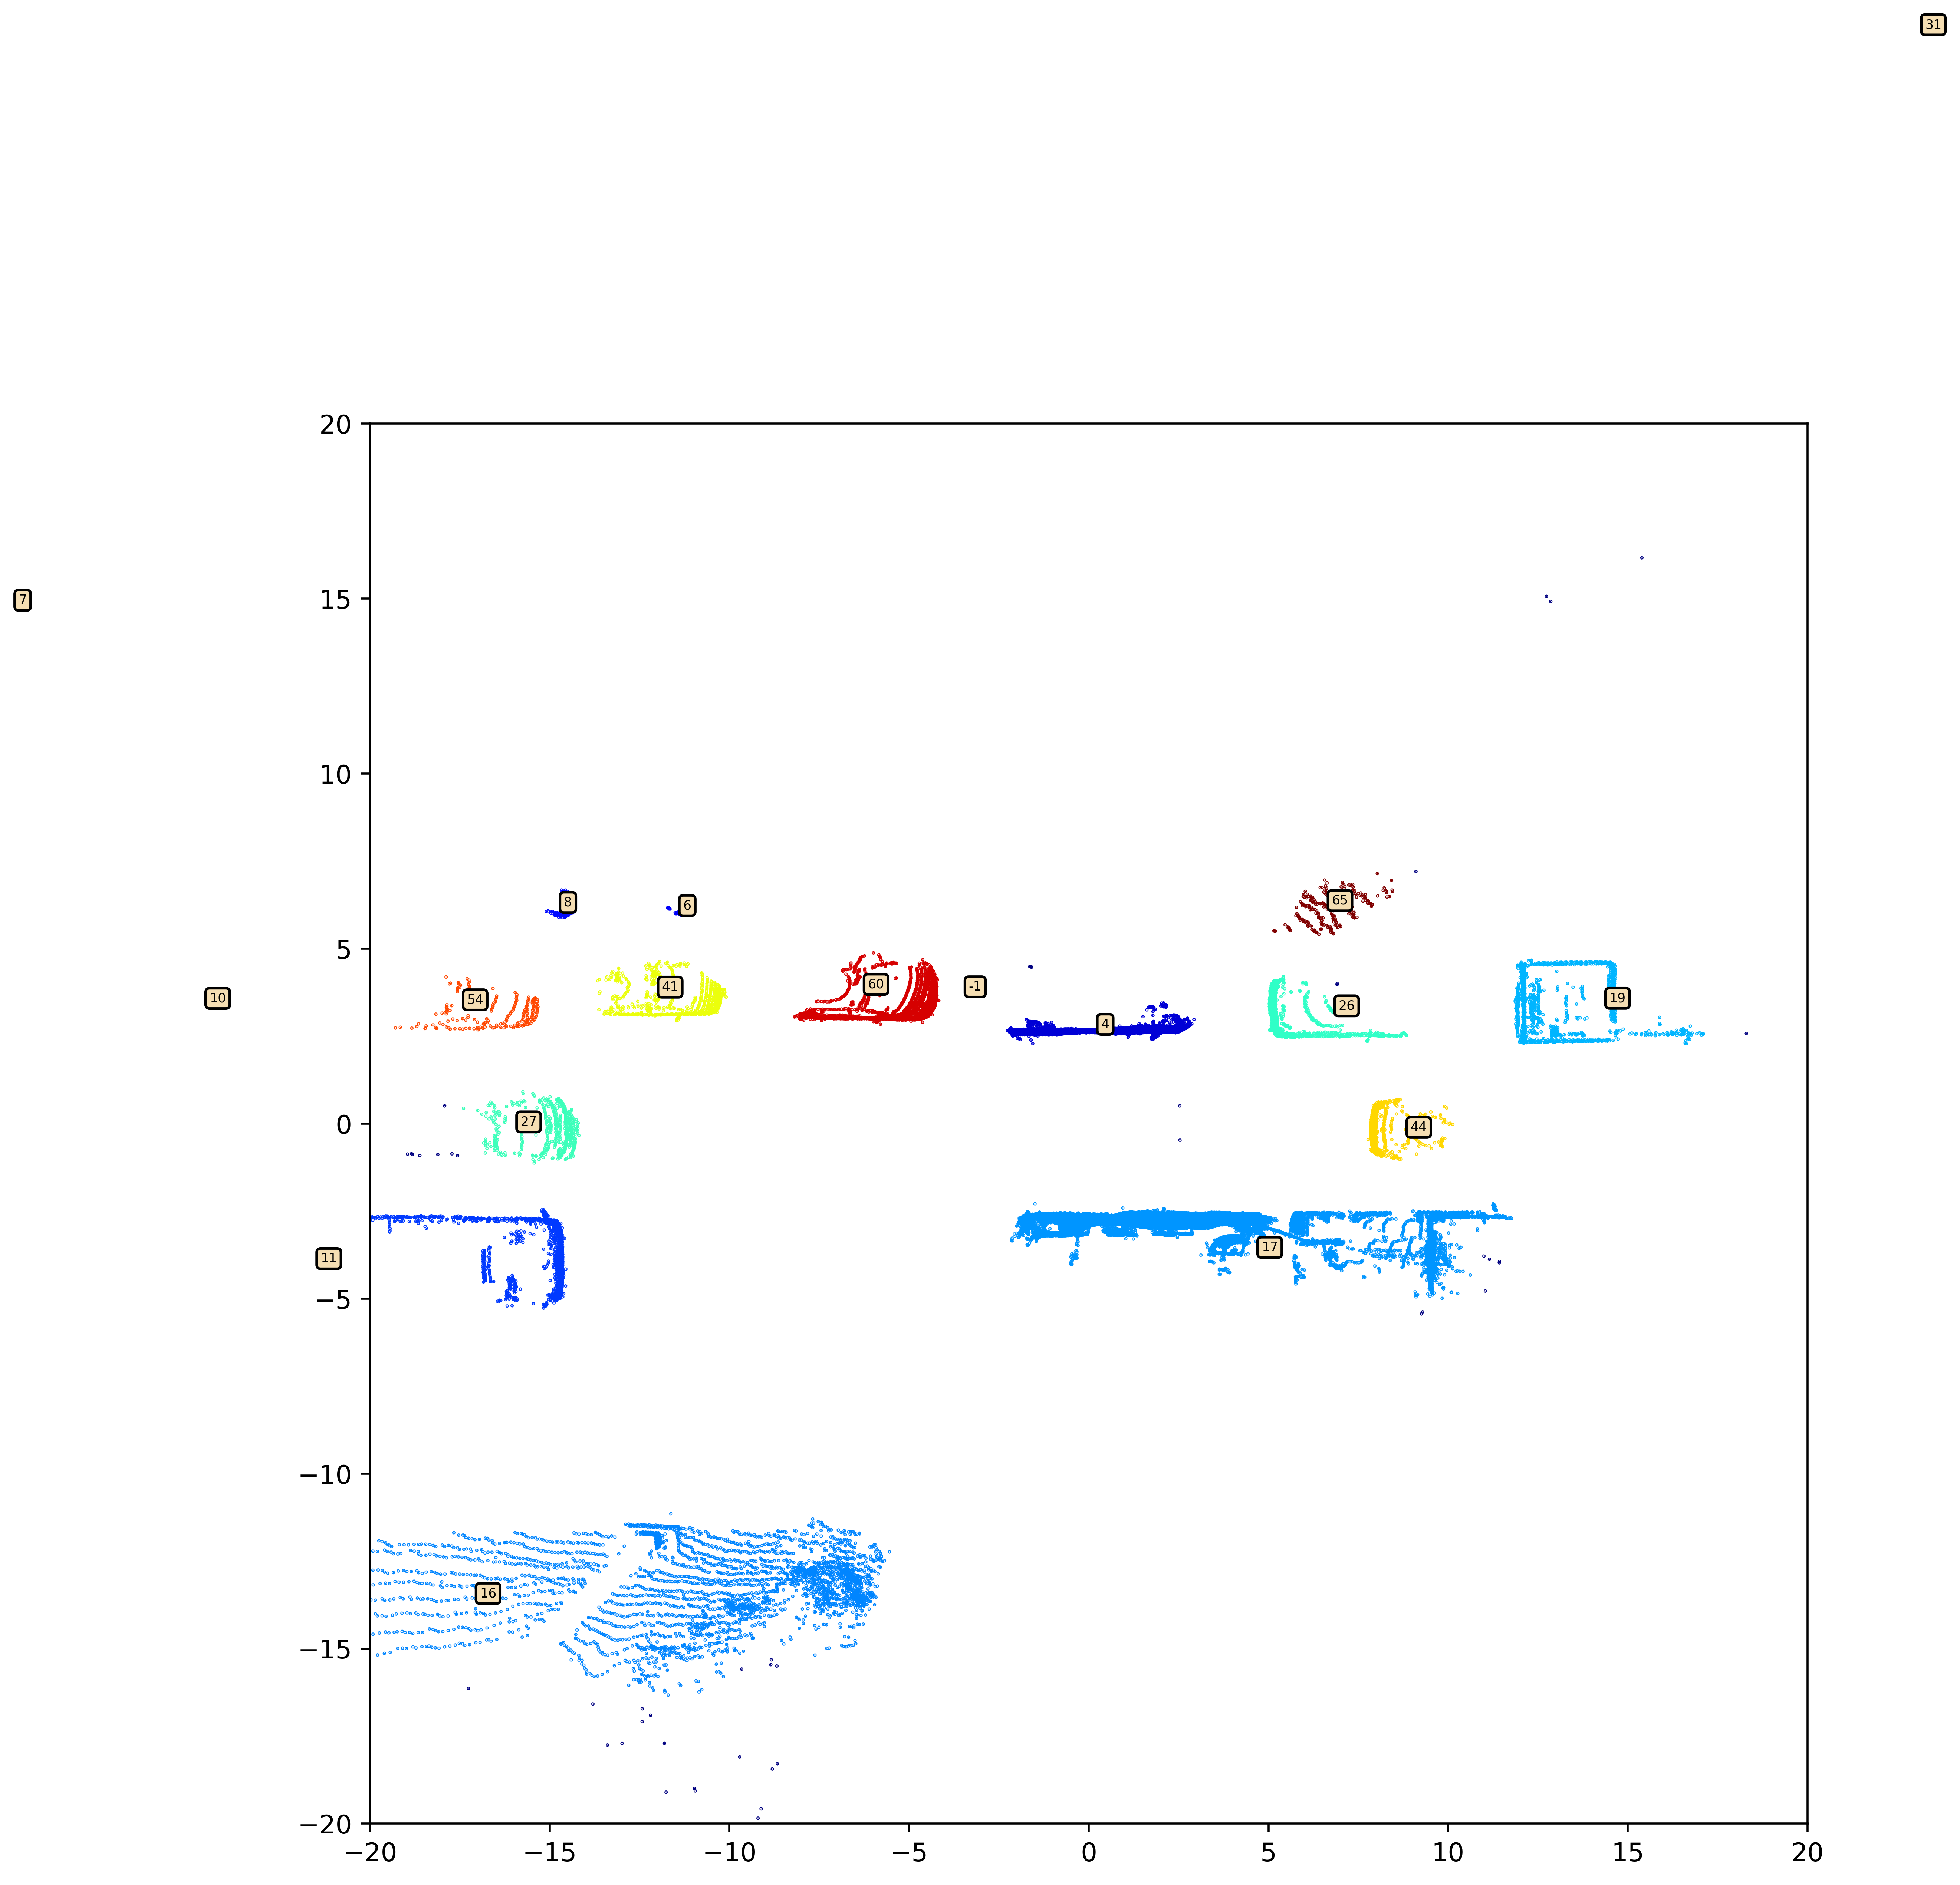

In [19]:
plt.figure(figsize=(10, 10), dpi=500)
plt.scatter(x=to_cluster2[:,0], y=to_cluster2[:,1], c=tracked_clst_labels2, s=0.1, cmap='jet')
for k in range(0,df2_t.shape[0]): 
    #plt.text(*df2_t.iloc[k,:2].values, str(int(df2_t.index.values[k])), fontsize=5, bbox=props)
    plt.text(*df2_t.iloc[k], str(int(df2_t.index.values[k])), fontsize=5, bbox=props)
plt.xlim(-20,20)
plt.ylim(-20,20)
#plt.savefig('df2_t.png')
#plt.show()

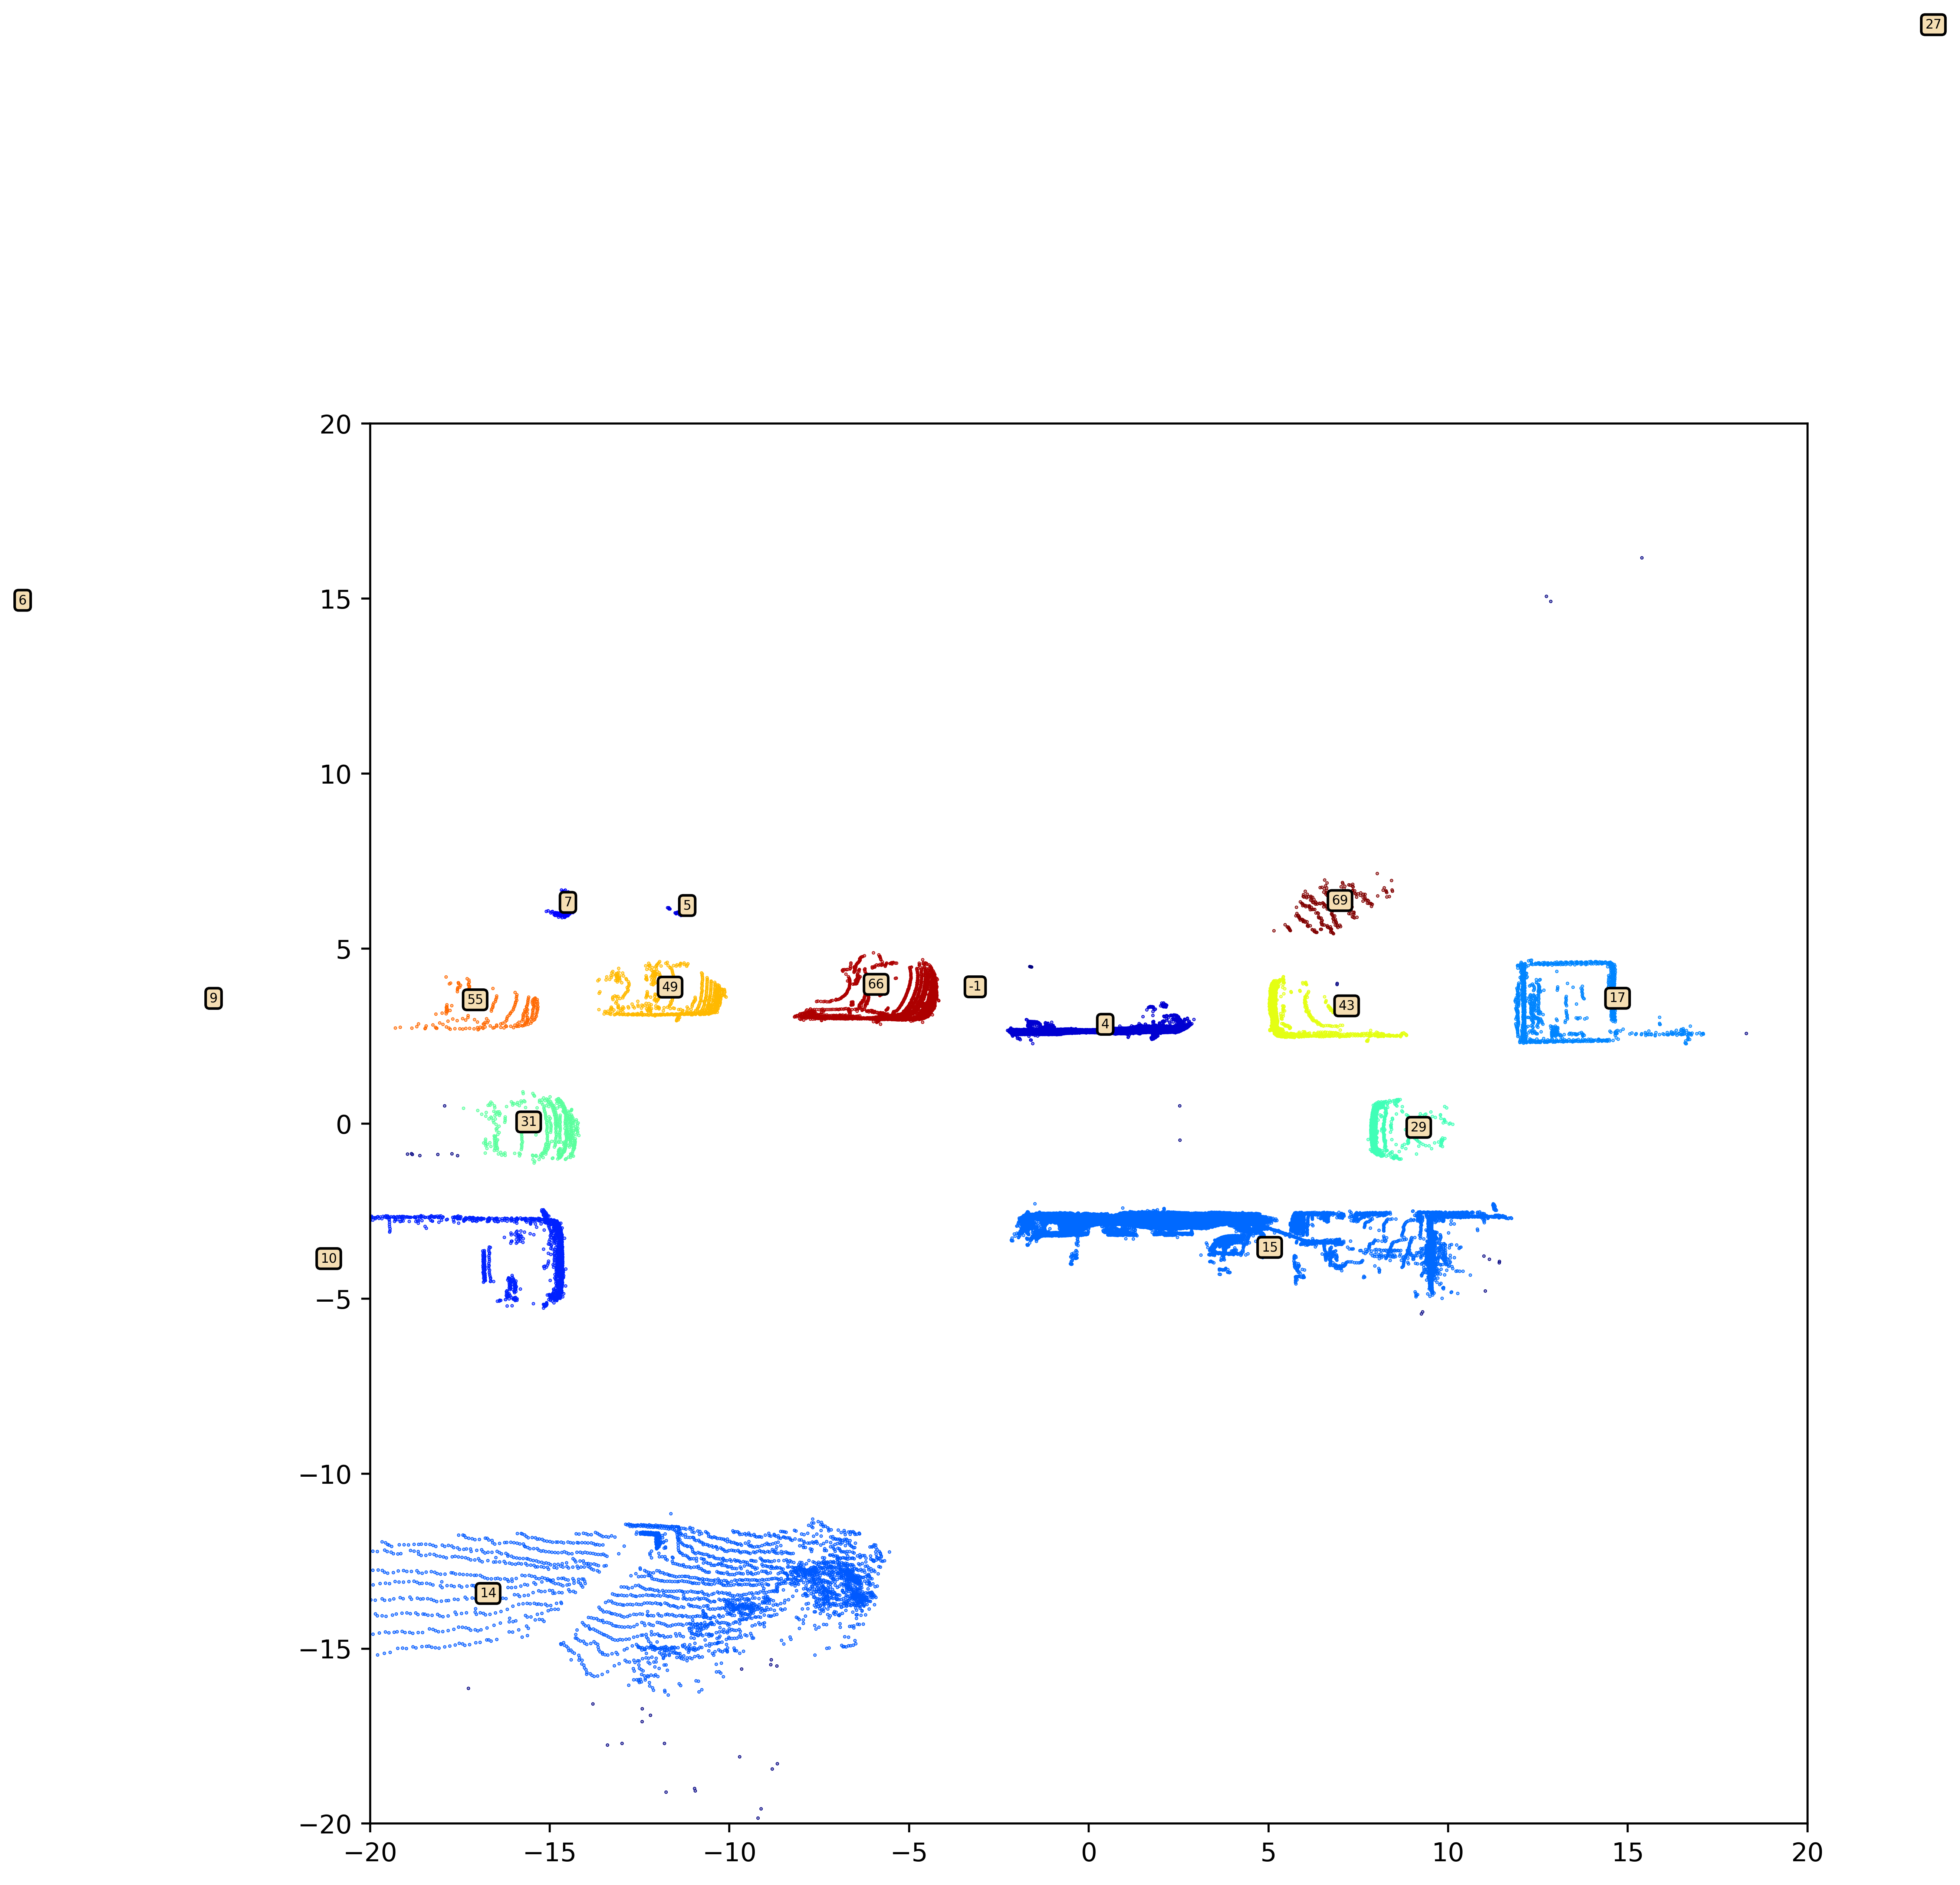

In [451]:
plt.figure(figsize=(10, 10), dpi=500)
plt.scatter(x=to_cluster2[:,0], y=to_cluster2[:,1], c=clst_labels2, s=0.1, cmap='jet')
for k in range(0,df2.shape[0]): 
    plt.text(*df2.iloc[k], str(int(df2.index.values[k])), fontsize=5, bbox=props)
plt.xlim(-20,20)
plt.ylim(-20,20)
plt.savefig('df2.png')
#plt.show()

In [298]:
v1 = pptk.viewer(*visualize_detections(to_cluster1, clst_labels1, bhulls1))
v1.set(lookat=[0,0,0])
v1.set(phi=np.pi, theta=np.pi/2, r=50)

v1 = pptk.viewer(*visualize_detections(to_cluster1, clst_labels1, bhulls1))
v1.set(lookat=[0,0,0])
v1.set(phi=np.pi, theta=np.pi/2, r=50)

v3 = pptk.viewer(*visualize_detections(to_cluster2, tracked_clst_labels2, bhulls2))
v3.set(lookat=[0,0,0])
v3.set(phi=np.pi, theta=np.pi/2, r=50)

v2 = pptk.viewer(*visualize_detections(to_cluster2, clst_labels2, bhulls2))
v2.set(lookat=[0,0,0])
v2.set(phi=np.pi, theta=np.pi/2, r=50)

In [ ]:
for k in np.unique(tracked_clst_labels2):
    v1=pptk.viewer(to_cluster1[clst_labels1==k])
    v1.set(r=150)
    v2=pptk.viewer(to_cluster2[tracked_clst_labels2==k])
    v2.set(r=150)
    v1.wait()
    v1.close()
    v2.close()

In [32]:
import numpy as np
import glob
import sys
sys.path.remove(sys.path[2])
import cv2

In [57]:
import os
img_array = []
for filename in sorted(glob.glob('output/*.png'), key=os.path.getmtime):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

In [58]:
out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()